# Classification de feuilles d'arbres

C'est ici un challenge Kaggle (https://www.kaggle.com/c/leaf-classification/) dont l'objectif est d'identifier le type de plante (99 au total) à partir d'images de feuilles et de caractéristiques extraites.  
Pour ça on va utiliser du Deep-Learning avec Keras.  
<img src="files/keras.png" alt="drawing" width="500">

Crédit : https://www.kaggle.com/abhmul/keras-convnet-lb-0-0052-w-visualization

### Import des packages que l'on va utiliser

In [1]:
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm_notebook

# Keras stuff
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [ ]:
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.VERSION)

### On fixe certains paramètres et l'aléatoire

In [2]:
root = os.getcwd()
np.random.seed(25)
split_random_state = 5
split = .85

### Définition de fonctions pour préparer les données

In [3]:
def load_numeric_training(standardize=True):
    """
    Loads the pre-extracted features for the training data
    and returns a tuple of the image ids, the data, and the labels
    """
    # Read data from the CSV file
    data = pd.read_csv(os.path.join(root, 'data/train.csv'))
    ID = data.pop('id')

    # Since the labels are textual, so we encode them categorically
    y = data.pop('species')
    y = LabelEncoder().fit(y).transform(y)
    # standardize the data by setting the mean to 0 and std to 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values

    return ID, X, y


def load_numeric_test(standardize=True):
    """
    Loads the pre-extracted features for the test data
    and returns a tuple of the image ids, the data
    """
    test = pd.read_csv(os.path.join(root, 'data/test.csv'))
    ID = test.pop('id')
    # standardize the data by setting the mean to 0 and std to 1
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test


def resize_img(img, max_dim=128):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(ids, max_dim=128, center=True):
    """
    Takes as input an array of image ids and loads the images as numpy
    arrays with the images resized so the longest side is max-dim length.
    If center is True, then will place the image in the center of
    the output array, otherwise it will be placed at the top-left corner.
    """
    # Initialize the output array
    # NOTE: Theano users comment line below and
    X = np.empty((len(ids), max_dim, max_dim, 1))
    # X = np.empty((len(ids), 1, max_dim, max_dim)) # uncomment this
    for i, idee in enumerate(tqdm_notebook(list(ids))):
        # Turn the image into an array
        #x = resize_img(load_img(os.path.join(root, 'data/images', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        
        x = load_img(os.path.join(root, 'data/images', str(idee) + '.jpg'), grayscale=True)     
        x = np.asarray(x, dtype=np.uint8)        
        x = cv2.resize(x, (max_dim, max_dim), interpolation=cv2.INTER_LINEAR)
        #x = cv2.Canny(x,100,200) # Les 100 et 200 sont des seuils du filtre à régler
        x = img_to_array(x)
        
        # Get the corners of the bounding box for the image
       
        length = x.shape[0]
        width = x.shape[1]
        
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        X[i, h1:h2, w1:w2, 0:1] = x
        
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)


def load_train_data(split=split, random_state=None):
    """
    Loads the pre-extracted feature and image training data and
    splits them into training and cross-validation.
    Returns one tuple for the training data and one for the validation
    data. Each tuple is in the order pre-extracted features, images,
    and labels.
    """
    # Load the pre-extracted features
    ID, X_num_tr, y = load_numeric_training()
    # Load the image data
    X_img_tr = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val)


def load_test_data():
    """
    Loads the pre-extracted feature and image test data.
    Returns a tuple in the order ids, pre-extracted features,
    and images.
    """
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

In [4]:
print('Loading the training data...')
(X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val) = load_train_data(random_state=split_random_state)
y_tr_cat = to_categorical(y_tr)
y_val_cat = to_categorical(y_val)
print('Training data loaded!')

Loading the training data...



Training data loaded!


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1788: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Les features numériques

In [5]:
train = pd.read_csv(os.path.join(root, 'data/train.csv'))
train.pop('id')
train.head()

,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [6]:
train.describe()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,0.018639,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,0.016071,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,0.005859,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,0.015625,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,0.027344,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,0.097656,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


#### Correlation map

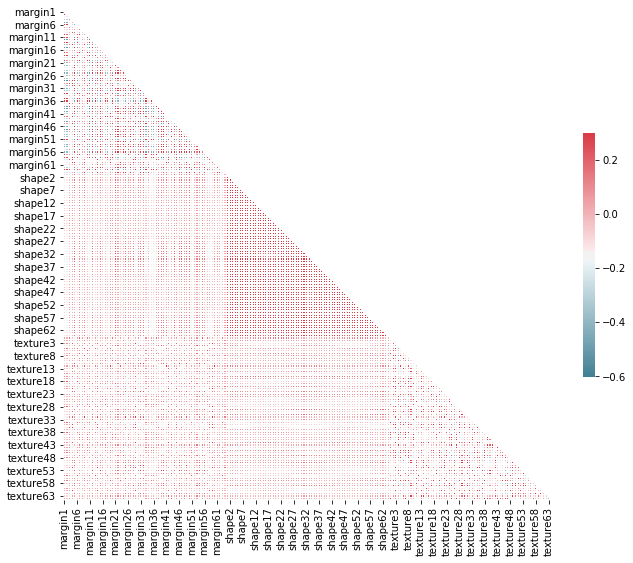

In [7]:
corr = train.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


## Visualisation de quelques images

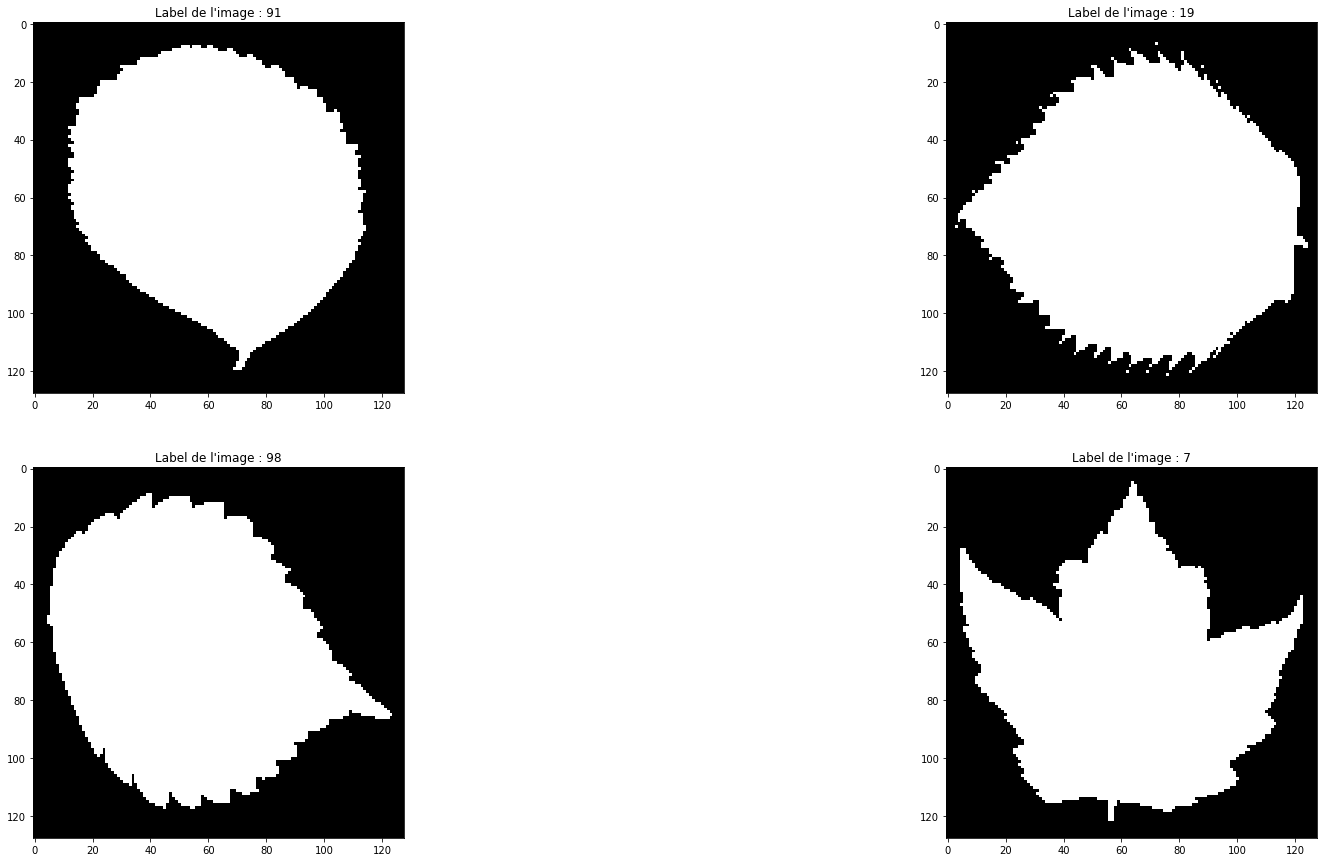

In [8]:
plt.figure(figsize=(30,15))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X_img_tr[i].reshape((128,128)), 'gray')
    plt.title('Label de l\'image : ' + str(y_tr[i]))
    

In [9]:
print('Nombre d\'images d\'entrainement :% 2d.' %(len(X_img_tr)))

Nombre d'images d'entrainement : 841.


C'est peu !!!

# Data Augmentation

On va utiliser un trick classique avec les CNN, pour augmenter notre jeu de donnéres et améliorer la robustesse de notre classifieur.

On va faire des rotations, des retournements horizontaux et verticaux, des zooms aléatoires, etc... Avec des images de couleur on peut aussi jouer sur le contraste, correction gamma etc..


**NOTE:** Ce n'est pas non plus magique vu qu'on ajoute aucune information extérieure.

In [10]:
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img

# Une toute petite modifs pour toujours avoir accès aux indices des images
class ImageDataGenerator2(ImageDataGenerator):
    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator2(
            x, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)


class NumpyArrayIterator2(NumpyArrayIterator):
    def next(self):
        # for python 2.x.
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            # We changed index_array to self.index_array
            self.index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.x.shape)[1:]))
        for i, j in enumerate(self.index_array):
            x = self.x[j]
            x = self.image_data_generator.random_transform(x.astype('float32'))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[self.index_array]
        return batch_x, batch_y

print('Creating Data Augmenter...')
imgen = ImageDataGenerator2(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest')
imgen_train = imgen.flow(X_img_tr, y_tr_cat, seed=42)
print('Finished making data augmenter...')

Creating Data Augmenter...
Finished making data augmenter...


# Combinaisons des features du CNN et des features extraites

Ca y est toutes nos données sont prêtes, on va pouvoir passer au modèle.

## Keras Functional API

Il existe ausi une```Keras's Sequential API```, encore plus simple mais nous ne pouvons pas l'utiliser ici à cause de cette combinaison entre réseau CNN et ajout des features pré-extraites.

In [11]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Input, concatenate, LeakyReLU
from keras.layers.normalization import BatchNormalization


def combined_model():

    # Define the image input
    image = Input(shape=(128, 128, 1), name='image')
    # Pass it through the first convolutional layer
    x = Conv2D(8, (5, 5), input_shape=(128, 128, 1), padding='same')(image)
    #x = (BatchNormalization())(x)
    x = (LeakyReLU(alpha=0.3))(x)
    #x = (Activation('relu'))(x)
    x = (Dropout(.5))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Conv2D(32, (5, 5), padding='same'))(x)
    #x = (BatchNormalization())(x)
    x = (LeakyReLU(alpha=0.3))(x)
    #x = (Activation('relu'))(x)
    x = (Dropout(.5))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)
    # Define the pre-extracted feature input
    numerical = Input(shape=(192,), name='numerical')
    # Concatenate the output of our convnet with our pre-extracted feature input
    concatenated = concatenate([x, numerical])

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu')(concatenated)
    x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax')(x)
    # How we create models with the Functional API
    model = Model(inputs=[image, numerical], outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

print('Creating the model...')
model = combined_model()
print('Model created!')

Creating the model...
Model created!


Pour que ça tourne vite il faut faire tourner sur GPU !

In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image (InputLayer)               (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 8)   208         image[0][0]                      
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 128, 128, 8)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 128, 128, 8)   0           leaky_re_lu_1[0][0]              
___________________________________________________________________________________________

In [16]:
plot_model(model, to_file='files/model_plot.png', show_shapes=True, show_layer_names=True)

NameError: name 'plot_model' is not defined

In [13]:
%%time
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model


def combined_generator(imgen, X):
    """
    A generator to train our keras neural network. It
    takes the image augmenter generator and the array
    of the pre-extracted features.
    It yields a minibatch and will run indefinitely
    """
    while True:
        for i in range(X.shape[0]):
            # Get the image batch and labels
            batch_img, batch_y = next(imgen)
            # This is where that change to the source code we
            # made will come in handy. We can now access the indicies
            # of the images that imgen gave us.
            x = X[imgen.index_array]
            yield [batch_img, x], batch_y

# autosave best Model
best_model_file = "weights/leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=0, save_best_only=True)
tbCallBack = TensorBoard(log_dir='./graph', histogram_freq=1, write_graph=True, write_images=True)

print('Training model...')
history = model.fit_generator(combined_generator(imgen_train, X_num_tr),
                              steps_per_epoch=np.ceil(X_num_tr.shape[0] / 32),
                              nb_epoch=150,
                              validation_data=([X_img_val, X_num_val], y_val_cat),
                              verbose=1,
                              callbacks=[best_model,tbCallBack ])

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=([array([[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=27.0, epochs=150)`


Epoch 1/150
27/27 [==============================] - 4s - loss: 4.6839 - acc: 0.0116 - val_loss: 6.9435 - val_acc: 0.0101
Epoch 2/150
27/27 [==============================] - 2s - loss: 4.0402 - acc: 0.1209 - val_loss: 4.4516 - val_acc: 0.0909
Epoch 3/150
27/27 [==============================] - 2s - loss: 3.1699 - acc: 0.2763 - val_loss: 3.2346 - val_acc: 0.2222
Epoch 4/150
27/27 [==============================] - 2s - loss: 2.4765 - acc: 0.4384 - val_loss: 2.4268 - val_acc: 0.3636
Epoch 5/150
27/27 [==============================] - 2s - loss: 1.9286 - acc: 0.5443 - val_loss: 1.8148 - val_acc: 0.5051
Epoch 6/150
27/27 [==============================] - 2s - loss: 1.5057 - acc: 0.6560 - val_loss: 2.2165 - val_acc: 0.3535
Epoch 7/150
27/27 [==============================] - 2s - loss: 1.2915 - acc: 0.6919 - val_loss: 0.9890 - val_acc: 0.6970
Epoch 8/150
27/27 [==============================] - 2s - loss: 1.0859 - acc: 0.7434 - val_loss: 0.7150 - val_acc: 0.8485
Epoch 9/150
27/27 [=====

## Maintenant on peut faire une prédiction sur le test 

In [14]:
# Get the names of the column headers
LABELS = sorted(pd.read_csv(os.path.join(root, 'data/train.csv')).species.unique())

index, test, X_img_te = load_test_data()

yPred_proba = model.predict([X_img_te, test])

# Converting the test predictions in a dataframe as depicted by sample submission
yPred = pd.DataFrame(yPred_proba,index=index,columns=LABELS)

print('Creating and writing submission...')
fp = open('sub/submit.csv', 'w')
fp.write(yPred.to_csv())
print('Finished writing submission')
# Display the submission
yPred.tail()


Creating and writing submission...
Finished writing submission


,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
id,,,,,,,,,,,,,,,,,,,,,
1576,6.731432e-10,9.997304e-01,3.537464e-11,4.148018e-13,2.951350e-07,2.777027e-11,1.363024e-13,8.330449e-09,1.124958e-07,3.778668e-08,...,2.340955e-14,1.815296e-18,1.234310e-10,9.993568e-12,2.362298e-13,2.545305e-09,2.474854e-10,2.795802e-16,1.037181e-11,8.944809e-08
1577,7.139310e-07,7.208855e-09,2.782369e-13,1.403099e-05,4.200142e-13,8.330543e-14,4.046104e-11,6.515445e-08,3.818917e-05,1.284213e-12,...,7.294882e-11,1.138120e-14,9.256779e-05,8.470935e-10,1.200374e-05,2.260189e-04,1.167869e-09,9.135226e-13,2.714115e-12,1.694542e-07
1579,3.743056e-09,1.989483e-10,1.057150e-15,6.783067e-15,1.965687e-13,3.191093e-10,9.655904e-18,3.019489e-12,1.055499e-14,4.234553e-08,...,6.204589e-19,3.176593e-20,4.622237e-11,5.454349e-12,2.075761e-12,2.842222e-16,2.881673e-19,4.396200e-14,3.232745e-14,3.085396e-09
1580,3.559128e-12,2.091235e-12,4.738518e-09,5.950179e-10,6.660015e-12,1.056922e-12,2.295983e-09,1.851823e-08,5.936833e-11,9.275717e-15,...,4.378006e-11,9.730683e-11,1.840765e-13,4.895065e-07,2.342486e-13,1.066940e-08,1.331237e-11,2.570882e-10,1.751569e-13,5.610892e-13
1583,4.723646e-14,1.944192e-09,1.776525e-09,1.170359e-08,5.627835e-11,6.326376e-07,3.640109e-08,1.357890e-11,2.086859e-10,2.709820e-11,...,1.045908e-12,1.877821e-15,3.511615e-10,2.940265e-11,1.933146e-10,5.089706e-09,3.497239e-13,4.099361e-13,8.080100e-14,7.603401e-11


# Visualization

Bon on peut quand même se demander ce qui a été appris par le CNN et que ces features ont un sens ! On va donc visualiser quelques couches cachées.  
On va donc prendre quelques images du set de validation, et on va les faire apsser à travers le réseau pour visualiser le résultats de différents filtrages à l'intérieur du CNN pour voir quelles parties sont activées.  
Dans notre architecture, il y a 8 filtres pour la première couches et 32 pour la seconde donc 40 images filtrées au total !

Top 3 Predicitons:
	Acer_Rufinerve: 0.9689772
	Betula_Austrosinensis: 0.030536307
	Tilia_Tomentosa: 0.00033553844

Actual: Acer_Rufinerve
Visualizing Convolutions Layer 0


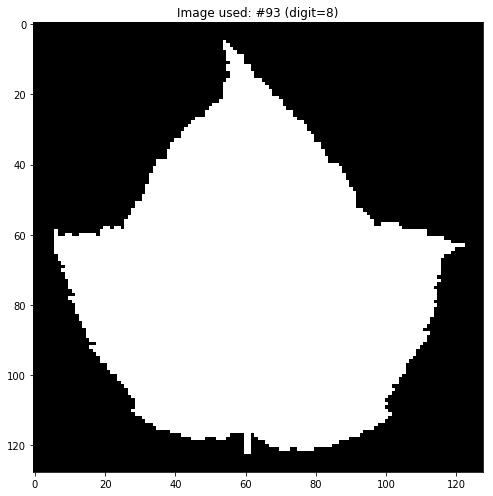

<Figure size 2160x1080 with 0 Axes>

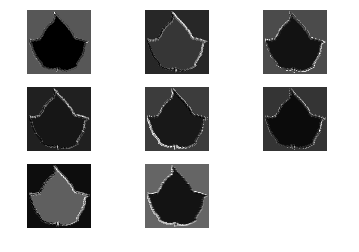

Visualizing Convolutions Layer 1


<Figure size 2160x1080 with 0 Axes>

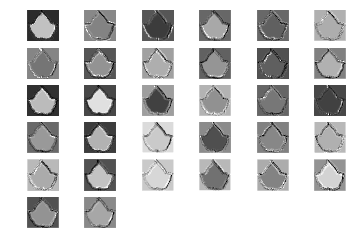

Top 3 Predicitons:
	Quercus_Afares: 0.99857306
	Quercus_Kewensis: 0.0013780767
	Acer_Opalus: 2.298736e-05

Actual: Quercus_Afares
Visualizing Convolutions Layer 0


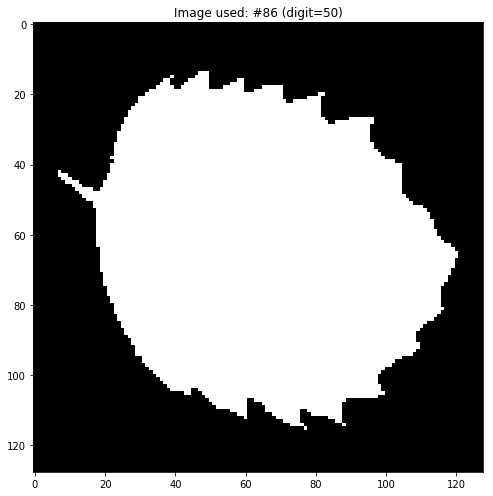

<Figure size 2160x1080 with 0 Axes>

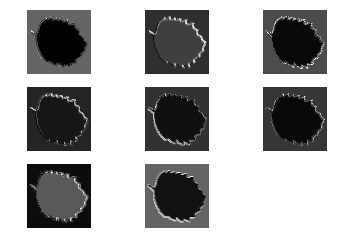

Visualizing Convolutions Layer 1


<Figure size 2160x1080 with 0 Axes>

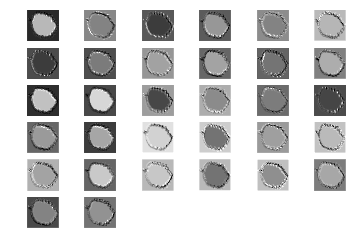

Top 3 Predicitons:
	Quercus_Palustris: 0.9910487
	Quercus_Shumardii: 0.0085849045
	Crataegus_Monogyna: 0.00028778144

Actual: Quercus_Palustris
Visualizing Convolutions Layer 0


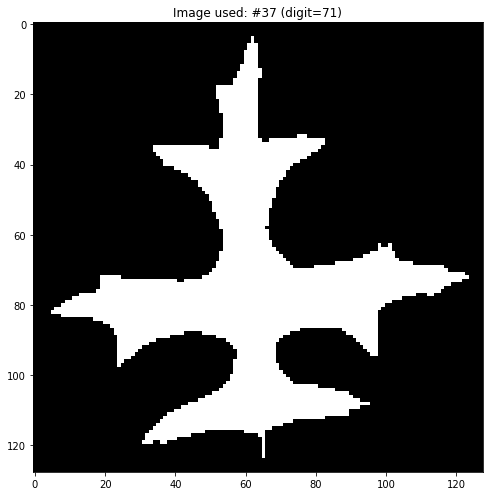

<Figure size 2160x1080 with 0 Axes>

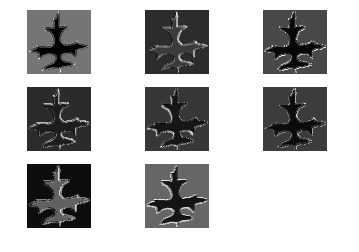

Visualizing Convolutions Layer 1


<Figure size 2160x1080 with 0 Axes>

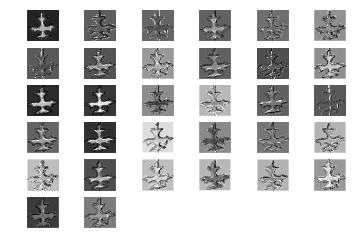

In [15]:
from math import sqrt

import matplotlib.pyplot as plt
from keras import backend as K

NUM_LEAVES = 3
model_fn = 'weights/leafnet.h5'

# Function by gcalmettes from http://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
def plot_figures(figures, nrows = 1, ncols=1, titles=False):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    plt.figure(figsize=(30,15))
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(sorted(figures.keys(), key=lambda s: int(s[3:]))):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        if titles:
            axeslist.ravel()[ind].set_title(title)

    for ind in range(nrows*ncols):
        axeslist.ravel()[ind].set_axis_off()

    if titles:
        plt.tight_layout()
    plt.show()


def get_dim(num):
    """
    Simple function to get the dimensions of a square-ish shape for plotting
    num images
    """

    s = sqrt(num)
    if round(s) < s:
        return (int(s), int(s)+1)
    else:
        return (int(s)+1, int(s)+1)

# Load the best model
model = load_model(model_fn)

# Get the convolutional layers
conv_layers = [layer for layer in model.layers if isinstance(layer, MaxPooling2D)]

# Pick random images to visualize
imgs_to_visualize = np.random.choice(np.arange(0, len(X_img_val)), NUM_LEAVES)

# Use a keras function to extract the conv layer data
convout_func = K.function([model.layers[0].input, K.learning_phase()], [layer.output for layer in conv_layers])
conv_imgs_filts = convout_func([X_img_val[imgs_to_visualize], 0])
# Also get the prediction so we know what we predicted
predictions = model.predict([X_img_val[imgs_to_visualize], X_num_val[imgs_to_visualize]])

imshow = plt.imshow #alias
# Loop through each image disply relevant info
for img_count, img_to_visualize in enumerate(imgs_to_visualize):

    # Get top 3 predictions
    top3_ind = predictions[img_count].argsort()[-3:]
    top3_species = np.array(LABELS)[top3_ind]
    top3_preds = predictions[img_count][top3_ind]

    # Get the actual leaf species
    actual = LABELS[y_val[img_to_visualize]]

    # Display the top 3 predictions and the actual species
    print("Top 3 Predicitons:")
    for i in range(2, -1, -1):
        print("\t%s: %s" % (top3_species[i], top3_preds[i]))
    print("\nActual: %s" % actual)

    # Show the original image
    plt.figure(figsize=(15,7))
    plt.title("Image used: #%d (digit=%d)" % (img_to_visualize, y_val[img_to_visualize]))
    imshow(X_img_val[img_to_visualize][:, :, 0], cmap='gray')
    plt.tight_layout()


    # Plot the filter images
    for i, conv_imgs_filt in enumerate(conv_imgs_filts):
        conv_img_filt = conv_imgs_filt[img_count]
        print("Visualizing Convolutions Layer %d" % i)
        # Get it ready for the plot_figures function
        
        fig_dict = {'flt{0}'.format(i): conv_img_filt[:, :, i] for i in range(conv_img_filt.shape[-1])}
        plot_figures(fig_dict, *get_dim(len(fig_dict)))